# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: no se puede crear el directorio «data»: El fichero ya existe


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

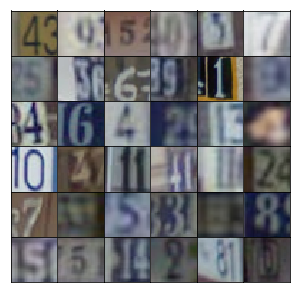

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generatoro(z, output_dim, reuse=False, alpha=0.2, training=True):
    kernel_size = 5
    strides = 2
    padding = 'same'
    use_bias = True
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer 4*4*512
        x = tf.layers.dense(z,4*4*512,activation=None,use_bias=use_bias)
        x = tf.reshape(x,(-1,4,4,512))
        x = tf.layers.batch_normalization(x,training = training)
        x = tf.nn.relu(x)
        
        #first transpose convolution 8*8*256
        x2 = tf.layers.conv2d_transpose(x,256,kernel_size,strides=strides,padding=padding,use_bias=use_bias)
        x2 = tf.layers.batch_normalization(x2,training = training)
        x2 = tf.nn.relu(x2)
        
        #second transpose convolution 16*16*128
        x3 = tf.layers.conv2d_transpose(x2,128,kernel_size,strides=strides,use_bias=use_bias)
        x3 = tf.layers.batch_normalization(x3,training=training)
        x3 = tf.nn.relu(x3)
        
        #third transpose convolution 32*32*64
        #x4 = tf.layers.conv2d_transpose(x3,64,kernel_size,strides=strides,use_bias=use_bias)
        #x4 = tf.layers.batch_normalization(x4,training=training)
        #x4 = tf.nn.relu(x4)
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3,output_dim,kernel_size,strides=strides)
        
        out = tf.tanh(logits)
        
        return out

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    kernel_size = 5
    strides = 2
    padding = 'same'
    use_bias = False
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z,4*4*512,activation=None,use_bias=use_bias)
        x = tf.reshape(x,(-1,4,4,512))
        x = tf.layers.batch_normalization(x,training = training)
        x = tf.nn.relu(x)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x,256,kernel_size,strides=strides,padding=padding,use_bias=use_bias)
        x2 = tf.layers.batch_normalization(x2,training = training)
        x2 = tf.nn.relu(x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2,128,kernel_size,strides=strides,padding=padding,use_bias=use_bias)
        x3 = tf.layers.batch_normalization(x3,training=training)
        x3 = tf.nn.relu(x3)
        
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [11]:
def discriminator(x, reuse=False, alpha=0.2):
    padding = 'same'
    kernel_size = 5
    strides = 2
    filters = 64
    use_bias = False
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        
        #first convolution 16,16 ,64
        x = tf.layers.conv2d(x,filters, kernel_size,strides=strides,padding=padding)
        x = tf.maximum(x,x*alpha)
        
        # second convolution 8,8 , 128
        filters*=2
        x1 = tf.layers.conv2d(x,filters,kernel_size,strides=strides,padding=padding,activation=None,use_bias=use_bias)
        x1 = tf.layers.batch_normalization(x1,training = True)
        x1 = tf.maximum(x1,x1*alpha)
        
        # third convolution 4,4 , 256
        filters*=2
        x2 = tf.layers.conv2d(x1,filters,kernel_size,strides=strides,padding=padding,activation=None,use_bias=use_bias)
        x2 = tf.layers.batch_normalization(x2,training= True)
        x2 = tf.maximum(x2,x2*alpha)
        
        flattened = tf.reshape(x2,(-1,4*4*filters))
        logits = tf.layers.dense(flattened,1,activation=None)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [12]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [14]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [15]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [16]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 0.7653... Generator Loss: 1.2660
Epoch 1/25... Discriminator Loss: 0.7403... Generator Loss: 0.9547
Epoch 1/25... Discriminator Loss: 0.1442... Generator Loss: 4.8371
Epoch 1/25... Discriminator Loss: 0.1219... Generator Loss: 3.9171
Epoch 1/25... Discriminator Loss: 0.2054... Generator Loss: 2.8818
Epoch 1/25... Discriminator Loss: 0.1448... Generator Loss: 2.6762
Epoch 1/25... Discriminator Loss: 0.3483... Generator Loss: 1.6644
Epoch 1/25... Discriminator Loss: 0.1636... Generator Loss: 2.8582
Epoch 1/25... Discriminator Loss: 0.2078... Generator Loss: 2.4960
Epoch 1/25... Discriminator Loss: 0.2482... Generator Loss: 2.4160


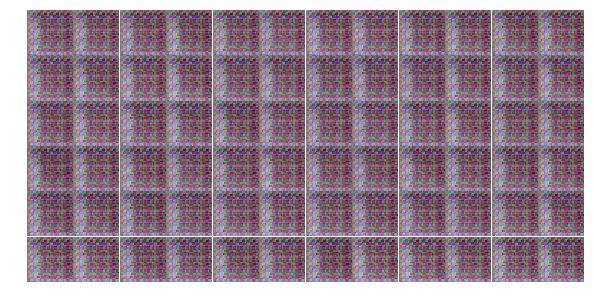

Epoch 1/25... Discriminator Loss: 0.2509... Generator Loss: 2.3473
Epoch 1/25... Discriminator Loss: 0.1852... Generator Loss: 2.6725
Epoch 1/25... Discriminator Loss: 0.1017... Generator Loss: 3.5164
Epoch 1/25... Discriminator Loss: 0.1552... Generator Loss: 2.9242
Epoch 1/25... Discriminator Loss: 0.2742... Generator Loss: 2.1534
Epoch 1/25... Discriminator Loss: 1.5497... Generator Loss: 0.9085
Epoch 1/25... Discriminator Loss: 0.6919... Generator Loss: 2.1416
Epoch 1/25... Discriminator Loss: 0.7732... Generator Loss: 1.3946
Epoch 1/25... Discriminator Loss: 0.6557... Generator Loss: 1.8728
Epoch 1/25... Discriminator Loss: 1.1069... Generator Loss: 1.6603


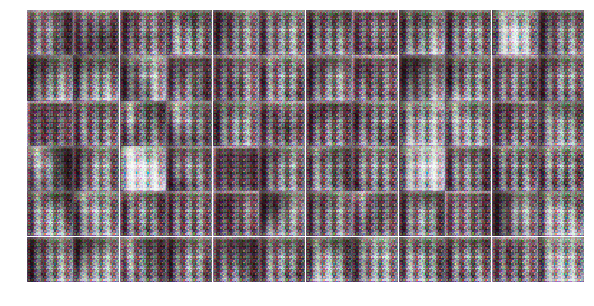

Epoch 1/25... Discriminator Loss: 0.7358... Generator Loss: 1.3802
Epoch 1/25... Discriminator Loss: 0.5959... Generator Loss: 1.5766
Epoch 1/25... Discriminator Loss: 0.6192... Generator Loss: 1.4265
Epoch 1/25... Discriminator Loss: 0.5137... Generator Loss: 1.4828
Epoch 1/25... Discriminator Loss: 0.3589... Generator Loss: 1.9828
Epoch 1/25... Discriminator Loss: 0.3293... Generator Loss: 2.1008
Epoch 1/25... Discriminator Loss: 0.8713... Generator Loss: 2.9397
Epoch 1/25... Discriminator Loss: 0.2719... Generator Loss: 2.1817
Epoch 1/25... Discriminator Loss: 0.2085... Generator Loss: 3.7711
Epoch 1/25... Discriminator Loss: 0.1789... Generator Loss: 3.8490


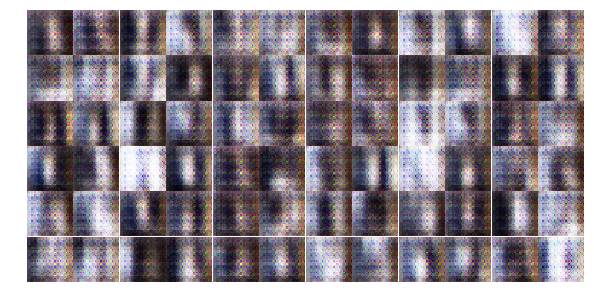

Epoch 1/25... Discriminator Loss: 0.2608... Generator Loss: 2.4482
Epoch 1/25... Discriminator Loss: 0.8601... Generator Loss: 0.8649
Epoch 1/25... Discriminator Loss: 0.5017... Generator Loss: 1.7809
Epoch 1/25... Discriminator Loss: 0.3067... Generator Loss: 2.6397
Epoch 1/25... Discriminator Loss: 0.6654... Generator Loss: 0.9500
Epoch 1/25... Discriminator Loss: 0.9752... Generator Loss: 1.5717
Epoch 1/25... Discriminator Loss: 0.7481... Generator Loss: 1.1730
Epoch 1/25... Discriminator Loss: 0.2049... Generator Loss: 3.8532
Epoch 1/25... Discriminator Loss: 0.1894... Generator Loss: 5.9072
Epoch 1/25... Discriminator Loss: 0.2007... Generator Loss: 3.0244


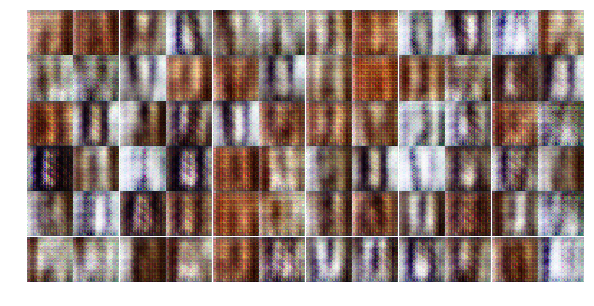

Epoch 1/25... Discriminator Loss: 0.2567... Generator Loss: 4.4284
Epoch 1/25... Discriminator Loss: 0.2600... Generator Loss: 6.1147
Epoch 1/25... Discriminator Loss: 1.1050... Generator Loss: 1.1698
Epoch 1/25... Discriminator Loss: 0.8376... Generator Loss: 1.0131
Epoch 1/25... Discriminator Loss: 0.5509... Generator Loss: 1.8620
Epoch 1/25... Discriminator Loss: 0.3894... Generator Loss: 1.7468
Epoch 1/25... Discriminator Loss: 0.5943... Generator Loss: 1.3855
Epoch 1/25... Discriminator Loss: 0.5069... Generator Loss: 1.3754
Epoch 1/25... Discriminator Loss: 0.6762... Generator Loss: 0.9397
Epoch 1/25... Discriminator Loss: 0.6504... Generator Loss: 1.4139


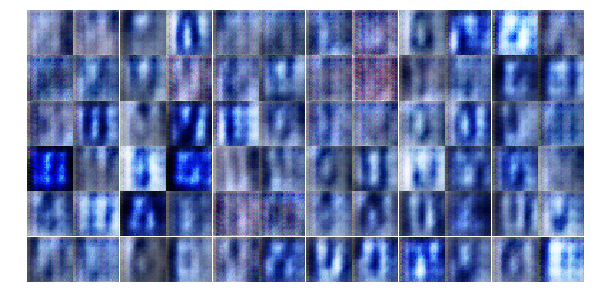

Epoch 1/25... Discriminator Loss: 0.7125... Generator Loss: 0.9309
Epoch 1/25... Discriminator Loss: 0.7596... Generator Loss: 2.4665
Epoch 1/25... Discriminator Loss: 0.2290... Generator Loss: 2.6926
Epoch 1/25... Discriminator Loss: 0.3321... Generator Loss: 3.1910
Epoch 1/25... Discriminator Loss: 0.6094... Generator Loss: 2.1309
Epoch 1/25... Discriminator Loss: 0.4287... Generator Loss: 1.6346
Epoch 1/25... Discriminator Loss: 0.4431... Generator Loss: 2.5096
Epoch 2/25... Discriminator Loss: 0.5549... Generator Loss: 1.4650
Epoch 2/25... Discriminator Loss: 0.1581... Generator Loss: 3.0677
Epoch 2/25... Discriminator Loss: 0.3228... Generator Loss: 1.9495


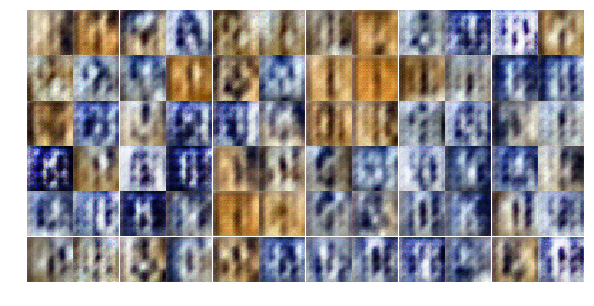

Epoch 2/25... Discriminator Loss: 0.4596... Generator Loss: 2.0239
Epoch 2/25... Discriminator Loss: 0.9339... Generator Loss: 0.7555
Epoch 2/25... Discriminator Loss: 0.6404... Generator Loss: 3.3522
Epoch 2/25... Discriminator Loss: 0.3278... Generator Loss: 3.8310
Epoch 2/25... Discriminator Loss: 0.1802... Generator Loss: 3.3187
Epoch 2/25... Discriminator Loss: 0.3932... Generator Loss: 1.5191
Epoch 2/25... Discriminator Loss: 4.3711... Generator Loss: 5.4123
Epoch 2/25... Discriminator Loss: 0.6280... Generator Loss: 1.3287
Epoch 2/25... Discriminator Loss: 0.6816... Generator Loss: 1.7804
Epoch 2/25... Discriminator Loss: 0.4630... Generator Loss: 1.8989


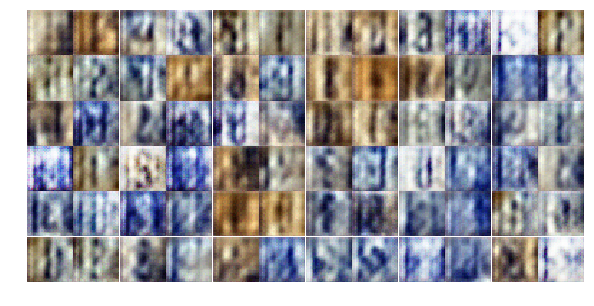

Epoch 2/25... Discriminator Loss: 1.4454... Generator Loss: 0.4347
Epoch 2/25... Discriminator Loss: 0.4513... Generator Loss: 1.5193
Epoch 2/25... Discriminator Loss: 0.2512... Generator Loss: 3.0207
Epoch 2/25... Discriminator Loss: 0.1974... Generator Loss: 3.4366
Epoch 2/25... Discriminator Loss: 0.5136... Generator Loss: 1.6660
Epoch 2/25... Discriminator Loss: 0.2460... Generator Loss: 2.2709
Epoch 2/25... Discriminator Loss: 0.8980... Generator Loss: 2.8991
Epoch 2/25... Discriminator Loss: 0.8482... Generator Loss: 2.3227
Epoch 2/25... Discriminator Loss: 1.5086... Generator Loss: 0.5307
Epoch 2/25... Discriminator Loss: 0.2855... Generator Loss: 2.6043


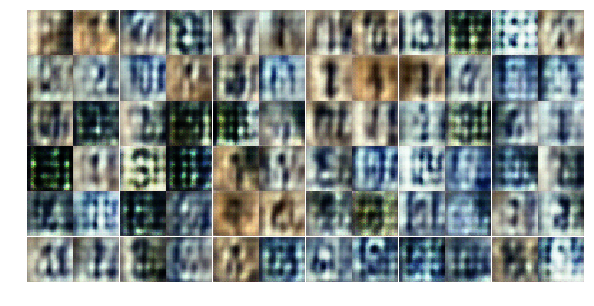

Epoch 2/25... Discriminator Loss: 1.0672... Generator Loss: 1.1234
Epoch 2/25... Discriminator Loss: 0.7909... Generator Loss: 1.6556
Epoch 2/25... Discriminator Loss: 0.6209... Generator Loss: 1.6377
Epoch 2/25... Discriminator Loss: 0.5961... Generator Loss: 1.7583
Epoch 2/25... Discriminator Loss: 0.5442... Generator Loss: 1.4206
Epoch 2/25... Discriminator Loss: 0.6931... Generator Loss: 1.0300
Epoch 2/25... Discriminator Loss: 1.2297... Generator Loss: 0.6674
Epoch 2/25... Discriminator Loss: 0.8274... Generator Loss: 0.8537
Epoch 2/25... Discriminator Loss: 0.8959... Generator Loss: 2.1260
Epoch 2/25... Discriminator Loss: 0.4624... Generator Loss: 2.4152


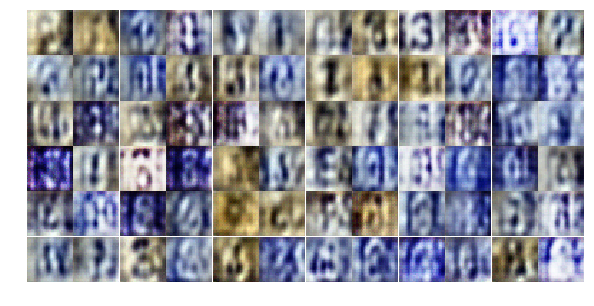

Epoch 2/25... Discriminator Loss: 0.2190... Generator Loss: 6.0978
Epoch 2/25... Discriminator Loss: 0.3687... Generator Loss: 1.6864
Epoch 2/25... Discriminator Loss: 0.1126... Generator Loss: 4.0319
Epoch 2/25... Discriminator Loss: 1.7687... Generator Loss: 0.2866
Epoch 2/25... Discriminator Loss: 1.1389... Generator Loss: 0.6362
Epoch 2/25... Discriminator Loss: 0.8931... Generator Loss: 2.3116
Epoch 2/25... Discriminator Loss: 0.4807... Generator Loss: 1.6068
Epoch 2/25... Discriminator Loss: 0.3213... Generator Loss: 3.2245
Epoch 2/25... Discriminator Loss: 0.5826... Generator Loss: 3.1615
Epoch 2/25... Discriminator Loss: 1.6527... Generator Loss: 0.3065


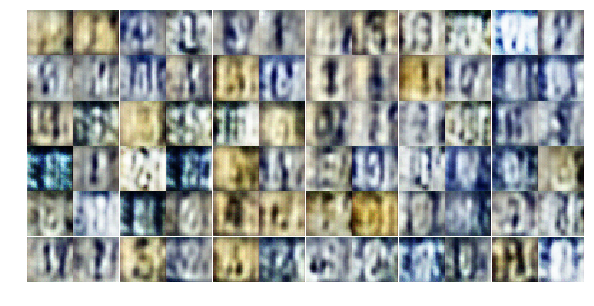

Epoch 2/25... Discriminator Loss: 0.5473... Generator Loss: 2.3436
Epoch 2/25... Discriminator Loss: 1.7623... Generator Loss: 2.2644
Epoch 2/25... Discriminator Loss: 0.5266... Generator Loss: 1.4242
Epoch 2/25... Discriminator Loss: 1.3827... Generator Loss: 0.4664
Epoch 2/25... Discriminator Loss: 0.5967... Generator Loss: 1.1518
Epoch 2/25... Discriminator Loss: 0.7096... Generator Loss: 2.7288
Epoch 2/25... Discriminator Loss: 0.2565... Generator Loss: 2.6869
Epoch 2/25... Discriminator Loss: 1.0388... Generator Loss: 0.6768
Epoch 2/25... Discriminator Loss: 0.4085... Generator Loss: 1.5249
Epoch 2/25... Discriminator Loss: 0.2243... Generator Loss: 2.3460


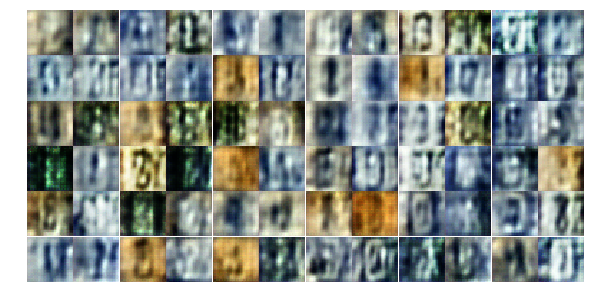

Epoch 2/25... Discriminator Loss: 0.1983... Generator Loss: 2.1142
Epoch 2/25... Discriminator Loss: 0.2054... Generator Loss: 2.7461
Epoch 2/25... Discriminator Loss: 0.2192... Generator Loss: 2.9181
Epoch 2/25... Discriminator Loss: 1.7945... Generator Loss: 3.9891
Epoch 3/25... Discriminator Loss: 0.7498... Generator Loss: 0.9588
Epoch 3/25... Discriminator Loss: 1.1744... Generator Loss: 0.7641
Epoch 3/25... Discriminator Loss: 0.7226... Generator Loss: 2.6489
Epoch 3/25... Discriminator Loss: 0.1934... Generator Loss: 3.5798
Epoch 3/25... Discriminator Loss: 0.4865... Generator Loss: 1.3202
Epoch 3/25... Discriminator Loss: 0.8096... Generator Loss: 2.3510


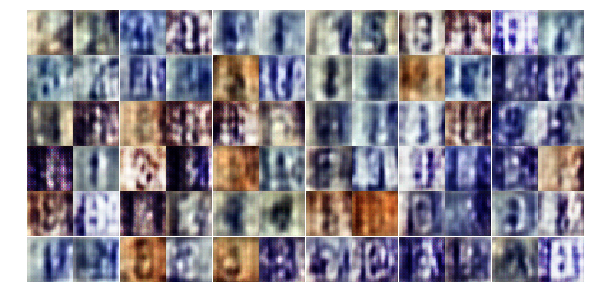

Epoch 3/25... Discriminator Loss: 0.2051... Generator Loss: 3.0186
Epoch 3/25... Discriminator Loss: 0.1172... Generator Loss: 2.7772
Epoch 3/25... Discriminator Loss: 1.2443... Generator Loss: 0.4872
Epoch 3/25... Discriminator Loss: 0.3933... Generator Loss: 3.0007
Epoch 3/25... Discriminator Loss: 0.1033... Generator Loss: 4.4786
Epoch 3/25... Discriminator Loss: 1.0231... Generator Loss: 0.6963
Epoch 3/25... Discriminator Loss: 0.8648... Generator Loss: 1.0169
Epoch 3/25... Discriminator Loss: 0.3915... Generator Loss: 3.0903
Epoch 3/25... Discriminator Loss: 0.4595... Generator Loss: 1.5960
Epoch 3/25... Discriminator Loss: 0.3500... Generator Loss: 1.6320


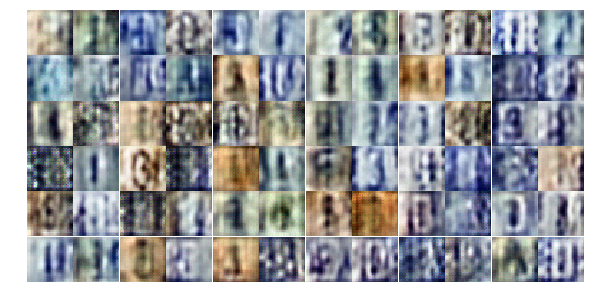

Epoch 3/25... Discriminator Loss: 1.9586... Generator Loss: 2.4132
Epoch 3/25... Discriminator Loss: 1.4686... Generator Loss: 0.8410
Epoch 3/25... Discriminator Loss: 1.3703... Generator Loss: 1.1848
Epoch 3/25... Discriminator Loss: 0.9612... Generator Loss: 1.7216
Epoch 3/25... Discriminator Loss: 1.2875... Generator Loss: 0.4617
Epoch 3/25... Discriminator Loss: 0.2567... Generator Loss: 2.5025
Epoch 3/25... Discriminator Loss: 0.9646... Generator Loss: 0.6346
Epoch 3/25... Discriminator Loss: 0.8394... Generator Loss: 0.9325
Epoch 3/25... Discriminator Loss: 0.5969... Generator Loss: 1.9593
Epoch 3/25... Discriminator Loss: 0.2743... Generator Loss: 2.1289


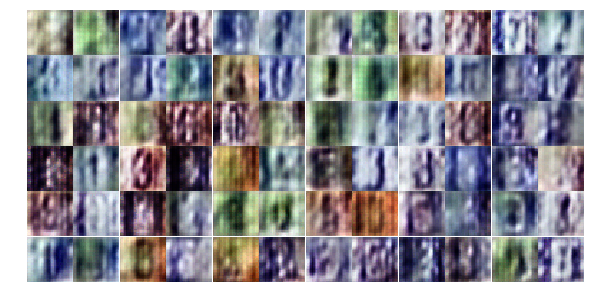

Epoch 3/25... Discriminator Loss: 1.0863... Generator Loss: 1.2580
Epoch 3/25... Discriminator Loss: 0.8399... Generator Loss: 1.6576
Epoch 3/25... Discriminator Loss: 0.3332... Generator Loss: 1.9083
Epoch 3/25... Discriminator Loss: 1.7540... Generator Loss: 1.8907
Epoch 3/25... Discriminator Loss: 0.2080... Generator Loss: 2.1973
Epoch 3/25... Discriminator Loss: 0.3648... Generator Loss: 1.8930
Epoch 3/25... Discriminator Loss: 1.0390... Generator Loss: 0.7554
Epoch 3/25... Discriminator Loss: 0.5400... Generator Loss: 3.2345
Epoch 3/25... Discriminator Loss: 0.4180... Generator Loss: 2.3080
Epoch 3/25... Discriminator Loss: 0.8472... Generator Loss: 0.8086


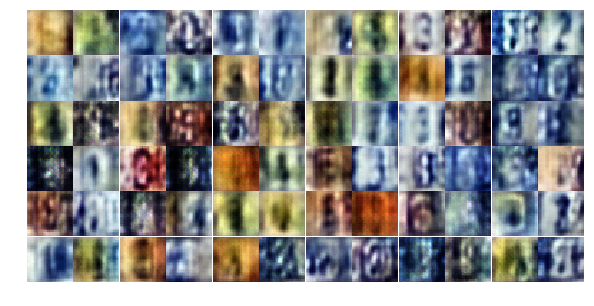

Epoch 3/25... Discriminator Loss: 0.4788... Generator Loss: 1.2698
Epoch 3/25... Discriminator Loss: 0.5180... Generator Loss: 3.8745
Epoch 3/25... Discriminator Loss: 1.2721... Generator Loss: 1.1917
Epoch 3/25... Discriminator Loss: 1.3656... Generator Loss: 0.5855
Epoch 3/25... Discriminator Loss: 0.1991... Generator Loss: 2.5578
Epoch 3/25... Discriminator Loss: 0.6199... Generator Loss: 1.1865
Epoch 3/25... Discriminator Loss: 0.3614... Generator Loss: 5.4942
Epoch 3/25... Discriminator Loss: 0.3374... Generator Loss: 2.3671
Epoch 3/25... Discriminator Loss: 1.2101... Generator Loss: 2.9749
Epoch 3/25... Discriminator Loss: 0.8163... Generator Loss: 0.8364


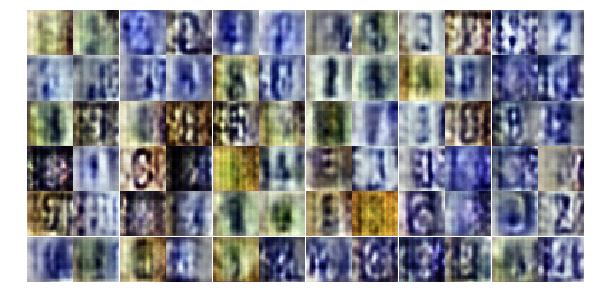

Epoch 3/25... Discriminator Loss: 0.5326... Generator Loss: 3.2257
Epoch 3/25... Discriminator Loss: 1.3233... Generator Loss: 0.4681
Epoch 3/25... Discriminator Loss: 0.6461... Generator Loss: 3.4112
Epoch 3/25... Discriminator Loss: 0.3878... Generator Loss: 3.3523
Epoch 3/25... Discriminator Loss: 0.6026... Generator Loss: 1.4529
Epoch 3/25... Discriminator Loss: 0.2182... Generator Loss: 2.0326
Epoch 3/25... Discriminator Loss: 0.7825... Generator Loss: 4.0072
Epoch 3/25... Discriminator Loss: 0.8028... Generator Loss: 1.2287
Epoch 3/25... Discriminator Loss: 0.4049... Generator Loss: 2.2558
Epoch 3/25... Discriminator Loss: 0.2520... Generator Loss: 2.4215


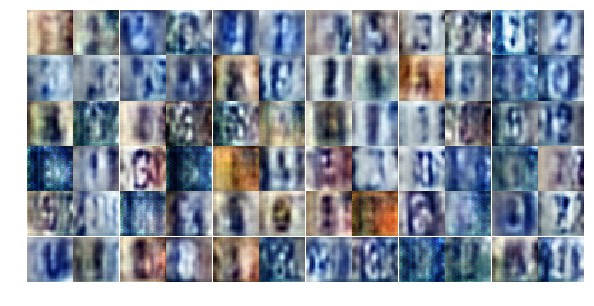

Epoch 3/25... Discriminator Loss: 1.0815... Generator Loss: 0.6479
Epoch 4/25... Discriminator Loss: 1.3031... Generator Loss: 1.9275
Epoch 4/25... Discriminator Loss: 0.2374... Generator Loss: 3.1098
Epoch 4/25... Discriminator Loss: 0.8589... Generator Loss: 1.1607
Epoch 4/25... Discriminator Loss: 0.9109... Generator Loss: 1.5377
Epoch 4/25... Discriminator Loss: 0.3573... Generator Loss: 2.8471
Epoch 4/25... Discriminator Loss: 0.7693... Generator Loss: 1.0931
Epoch 4/25... Discriminator Loss: 0.8511... Generator Loss: 0.9159
Epoch 4/25... Discriminator Loss: 2.3454... Generator Loss: 3.0483
Epoch 4/25... Discriminator Loss: 0.6547... Generator Loss: 1.4838


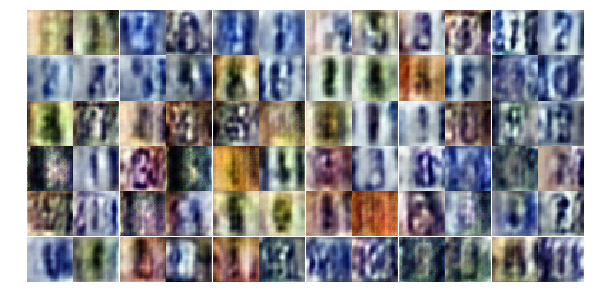

Epoch 4/25... Discriminator Loss: 0.1089... Generator Loss: 3.5828
Epoch 4/25... Discriminator Loss: 0.6037... Generator Loss: 2.5832
Epoch 4/25... Discriminator Loss: 0.9615... Generator Loss: 1.3339
Epoch 4/25... Discriminator Loss: 0.1331... Generator Loss: 3.2495
Epoch 4/25... Discriminator Loss: 2.4377... Generator Loss: 0.1161
Epoch 4/25... Discriminator Loss: 0.1467... Generator Loss: 2.9079
Epoch 4/25... Discriminator Loss: 0.9490... Generator Loss: 0.6551
Epoch 4/25... Discriminator Loss: 1.4305... Generator Loss: 0.3647
Epoch 4/25... Discriminator Loss: 1.0610... Generator Loss: 0.8970
Epoch 4/25... Discriminator Loss: 1.0321... Generator Loss: 0.6001


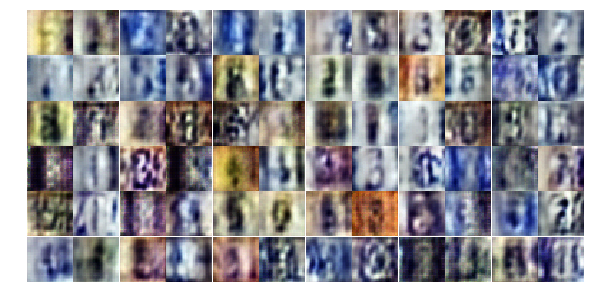

Epoch 4/25... Discriminator Loss: 1.1140... Generator Loss: 0.6215
Epoch 4/25... Discriminator Loss: 1.0129... Generator Loss: 0.6896
Epoch 4/25... Discriminator Loss: 0.3080... Generator Loss: 6.5535
Epoch 4/25... Discriminator Loss: 0.2246... Generator Loss: 2.6537
Epoch 4/25... Discriminator Loss: 1.6141... Generator Loss: 0.3434
Epoch 4/25... Discriminator Loss: 0.2355... Generator Loss: 2.5929
Epoch 4/25... Discriminator Loss: 0.2833... Generator Loss: 4.0130
Epoch 4/25... Discriminator Loss: 1.1855... Generator Loss: 2.0751
Epoch 4/25... Discriminator Loss: 1.5363... Generator Loss: 2.4521
Epoch 4/25... Discriminator Loss: 0.8321... Generator Loss: 1.4460


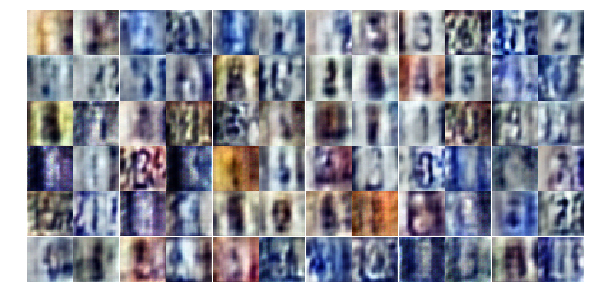

Epoch 4/25... Discriminator Loss: 0.5451... Generator Loss: 2.8992
Epoch 4/25... Discriminator Loss: 0.5329... Generator Loss: 2.7534
Epoch 4/25... Discriminator Loss: 0.6941... Generator Loss: 1.9048
Epoch 4/25... Discriminator Loss: 1.2072... Generator Loss: 0.4677
Epoch 4/25... Discriminator Loss: 0.3584... Generator Loss: 3.0182
Epoch 4/25... Discriminator Loss: 0.3699... Generator Loss: 1.9035
Epoch 4/25... Discriminator Loss: 0.6234... Generator Loss: 0.9477
Epoch 4/25... Discriminator Loss: 0.9907... Generator Loss: 1.2781
Epoch 4/25... Discriminator Loss: 1.1477... Generator Loss: 0.6569
Epoch 4/25... Discriminator Loss: 1.0396... Generator Loss: 1.6438


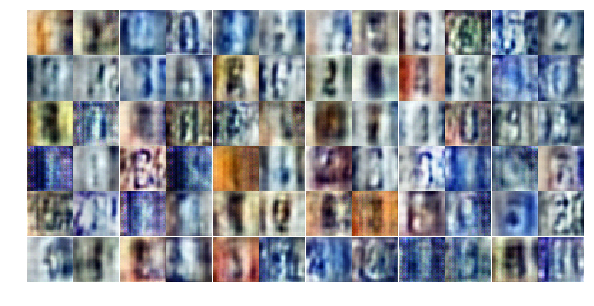

Epoch 4/25... Discriminator Loss: 0.9802... Generator Loss: 1.2993
Epoch 4/25... Discriminator Loss: 0.1400... Generator Loss: 3.7024
Epoch 4/25... Discriminator Loss: 1.5538... Generator Loss: 0.3539
Epoch 4/25... Discriminator Loss: 0.6941... Generator Loss: 3.0535
Epoch 4/25... Discriminator Loss: 0.5627... Generator Loss: 1.8880
Epoch 4/25... Discriminator Loss: 1.1817... Generator Loss: 0.5314
Epoch 4/25... Discriminator Loss: 1.6900... Generator Loss: 0.2851
Epoch 4/25... Discriminator Loss: 0.3452... Generator Loss: 2.6034
Epoch 4/25... Discriminator Loss: 1.2724... Generator Loss: 2.0009
Epoch 4/25... Discriminator Loss: 2.1743... Generator Loss: 4.0095


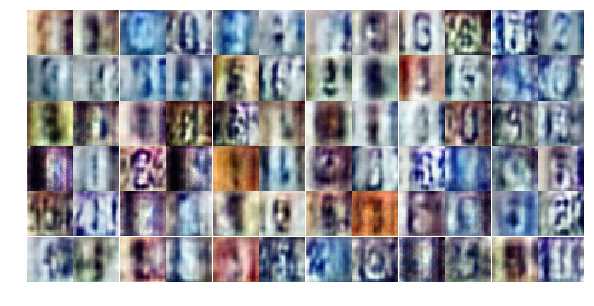

Epoch 4/25... Discriminator Loss: 1.2520... Generator Loss: 0.7138
Epoch 4/25... Discriminator Loss: 0.2180... Generator Loss: 3.1879
Epoch 4/25... Discriminator Loss: 0.3925... Generator Loss: 1.4310
Epoch 4/25... Discriminator Loss: 0.2046... Generator Loss: 3.3982
Epoch 4/25... Discriminator Loss: 0.2387... Generator Loss: 4.7797
Epoch 4/25... Discriminator Loss: 0.1174... Generator Loss: 3.7818
Epoch 4/25... Discriminator Loss: 1.9524... Generator Loss: 0.1979
Epoch 4/25... Discriminator Loss: 1.0479... Generator Loss: 1.1536
Epoch 4/25... Discriminator Loss: 0.8802... Generator Loss: 0.7536
Epoch 5/25... Discriminator Loss: 0.3377... Generator Loss: 1.6882


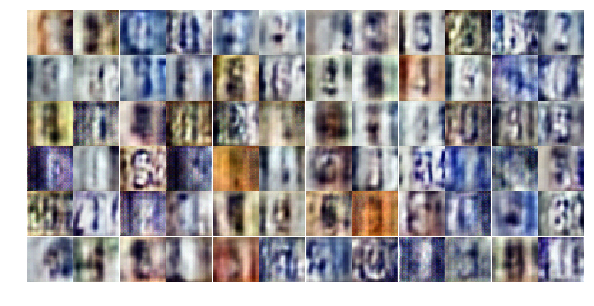

Epoch 5/25... Discriminator Loss: 0.1538... Generator Loss: 3.5667
Epoch 5/25... Discriminator Loss: 1.0962... Generator Loss: 0.5612
Epoch 5/25... Discriminator Loss: 0.1530... Generator Loss: 3.7618
Epoch 5/25... Discriminator Loss: 0.7259... Generator Loss: 0.8505
Epoch 5/25... Discriminator Loss: 0.6507... Generator Loss: 1.6210
Epoch 5/25... Discriminator Loss: 1.1831... Generator Loss: 0.4829
Epoch 5/25... Discriminator Loss: 0.8836... Generator Loss: 0.9729
Epoch 5/25... Discriminator Loss: 0.4281... Generator Loss: 1.7895
Epoch 5/25... Discriminator Loss: 0.4496... Generator Loss: 1.6643
Epoch 5/25... Discriminator Loss: 1.6753... Generator Loss: 2.0851


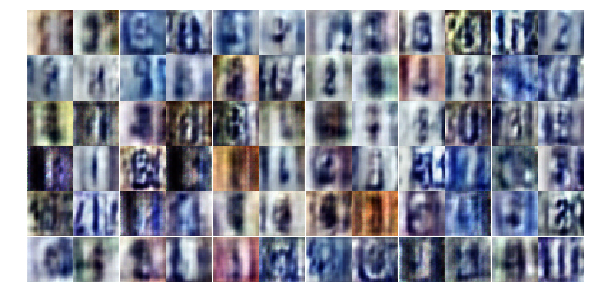

Epoch 5/25... Discriminator Loss: 0.6820... Generator Loss: 1.0032
Epoch 5/25... Discriminator Loss: 0.6140... Generator Loss: 0.9686
Epoch 5/25... Discriminator Loss: 0.5152... Generator Loss: 3.0085
Epoch 5/25... Discriminator Loss: 0.2454... Generator Loss: 3.1640
Epoch 5/25... Discriminator Loss: 1.4107... Generator Loss: 0.4286
Epoch 5/25... Discriminator Loss: 1.4201... Generator Loss: 0.5135
Epoch 5/25... Discriminator Loss: 1.9031... Generator Loss: 0.2647
Epoch 5/25... Discriminator Loss: 0.3102... Generator Loss: 1.7456
Epoch 5/25... Discriminator Loss: 0.5152... Generator Loss: 1.1394
Epoch 5/25... Discriminator Loss: 0.7996... Generator Loss: 0.7383


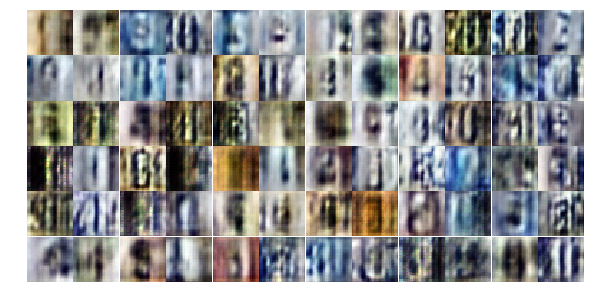

Epoch 5/25... Discriminator Loss: 0.8075... Generator Loss: 2.4122
Epoch 5/25... Discriminator Loss: 1.1159... Generator Loss: 1.1594
Epoch 5/25... Discriminator Loss: 0.5402... Generator Loss: 1.3477
Epoch 5/25... Discriminator Loss: 0.3130... Generator Loss: 1.6258
Epoch 5/25... Discriminator Loss: 1.7702... Generator Loss: 0.2736
Epoch 5/25... Discriminator Loss: 0.6860... Generator Loss: 1.7235
Epoch 5/25... Discriminator Loss: 1.5359... Generator Loss: 0.3595
Epoch 5/25... Discriminator Loss: 0.8136... Generator Loss: 0.7934
Epoch 5/25... Discriminator Loss: 0.5248... Generator Loss: 3.5255
Epoch 5/25... Discriminator Loss: 0.5404... Generator Loss: 1.8926


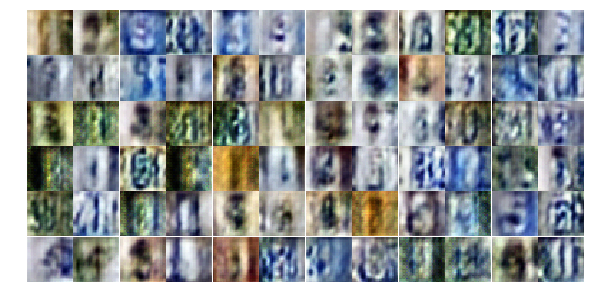

Epoch 5/25... Discriminator Loss: 0.4311... Generator Loss: 2.7110
Epoch 5/25... Discriminator Loss: 1.0260... Generator Loss: 0.7922


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))